# Decision Tree dataset Diabetes
L'obbiettivo che ci poniamo è quello di analizzare lo stato di avanzamento della malattia del diabete sfruttando un modello di predizione tra i vari disponibili per i problemi di regressione. In particolare ho scelto il DecisionTreeRegression, non per la sua particolare efficienza in relazione a questo problema, ma semplicemente a scopo didattico ai fini delle richieste per il progetto di Start2impact.
Il dataset in questione è il "load_diabetes" , disponibile nativamente all'interno della libreria Scikit-learn.

E' così composto:

- age: age in years
- sex: sex
- bmi: body mass index
- bp: average blood pressure
- s1: tc, total serum cholesterol
- s2: ldl, low-density lipoproteins
- s3: hdl, high-density lipoproteins
- s4: tch, total cholesterol / HDL
- s5: ltg, possibly log of serum triglycerides level
- s6: glu, blood sugar level

Il target è una misura quantitativa della progressione della malattia un anno seguente dalla contrazione.

## Importo librerie e carico i dati <a class="anchor" id="chapter1"></a>

In [1]:
#Importo librerie
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import datasets
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#Setto stile grafici
sns.set_style('darkgrid')
sns.set_context('talk')

warnings.filterwarnings('ignore')

In [2]:
#importo dataset
diabetes = datasets.load_diabetes()
X = diabetes['data']
y = diabetes['target']

In [3]:
#creo il dataset df_diabetes
df = pd.DataFrame(diabetes["data"], columns=diabetes["feature_names"])
df_target = pd.DataFrame(diabetes["target"], columns=["target"])
df_diabetes = pd.concat([df, df_target], axis=1)
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [4]:
#visualizzo il tipo delle colonne e verifico l'esistenza di eventuali valori nulli
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'bp'}>,
        <AxesSubplot:title={'center':'s1'}>,
        <AxesSubplot:title={'center':'s2'}>],
       [<AxesSubplot:title={'center':'s3'}>,
        <AxesSubplot:title={'center':'s4'}>,
        <AxesSubplot:title={'center':'s5'}>],
       [<AxesSubplot:title={'center':'s6'}>,
        <AxesSubplot:title={'center':'target'}>, <AxesSubplot:>]],
      dtype=object)

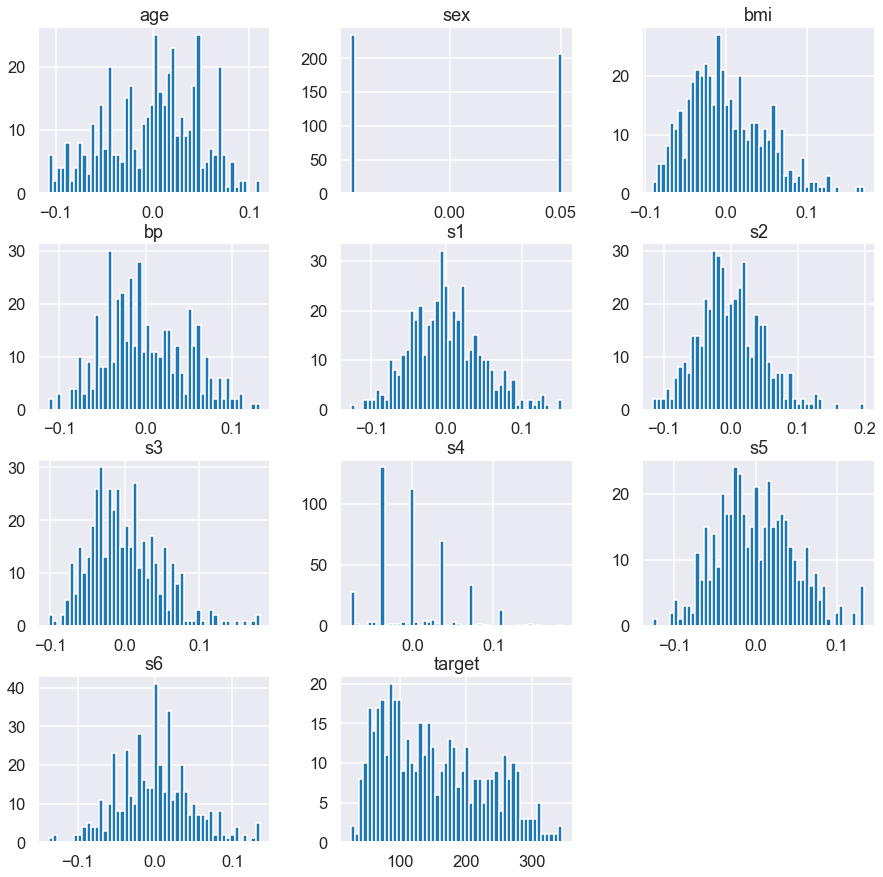

In [5]:
#visualizzo le distribuzioni delle features e del target
df_diabetes.hist(bins=50, figsize=(15, 15))

Text(0.5, 1.0, 'Correlazione tra dati')

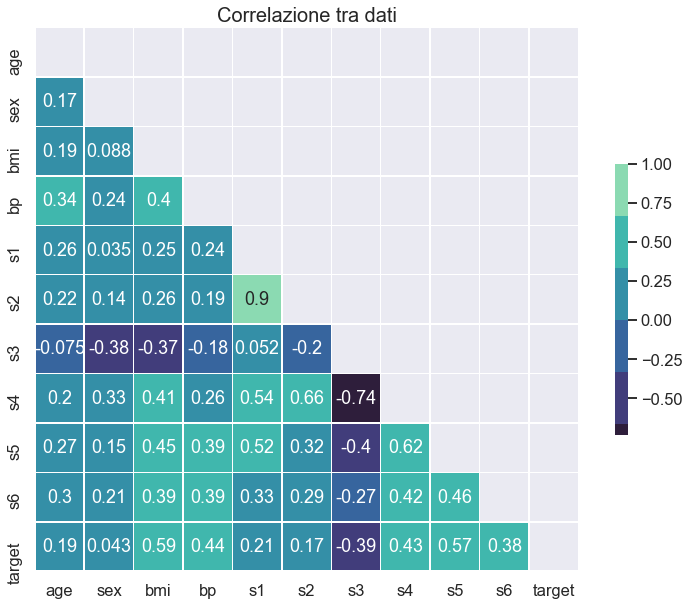

In [6]:
#Valuto correlazioni tra le features e tra le features e il target
corr= df_diabetes.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(13, 10))
cmap=sns.color_palette("mako")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True,annot=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlazione tra dati', size=20)

Alcune delle features sono tra loro correlate. In particolare notiamo che i valori di s1 e s2 hanno una forte correlazione di Pearson pari al 0.9, stessa cosa per le features s3 e s4, ma negativa pari al 0.74.
In relazione al target invece non notiamo correlazioni molto forti e possiamo da queste evidenziare solo correlazioni moderate con la feature bmi, bp, s4, s5

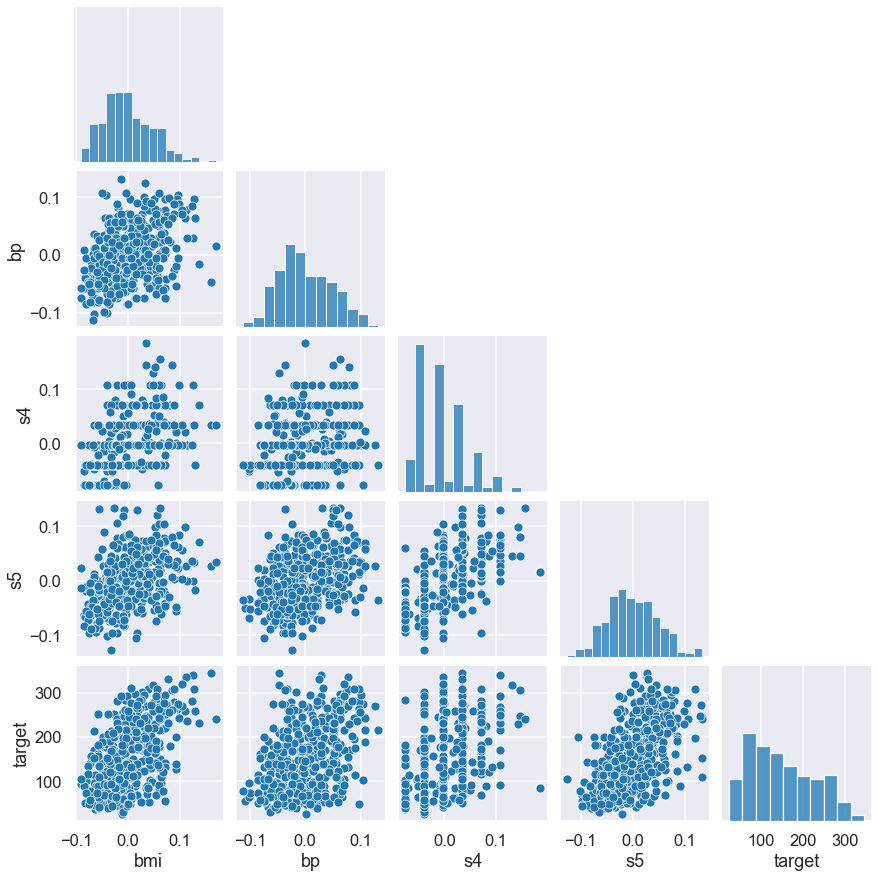

In [7]:
#visualizzo le correlazioni delle feature più significative con il target
cols= ["bmi", "bp", "s4", "s5", "target"]
sns.pairplot(df_diabetes[cols], corner=True);

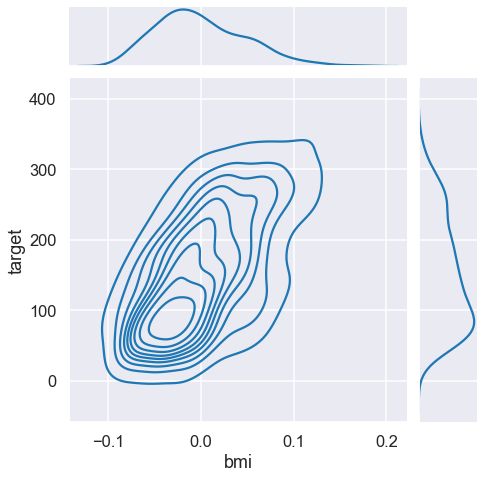

In [8]:
#Distribuzione tra bmi e il target
sns.jointplot(df.bmi, df_target.target, kind="kde", size=7)
plt.show()

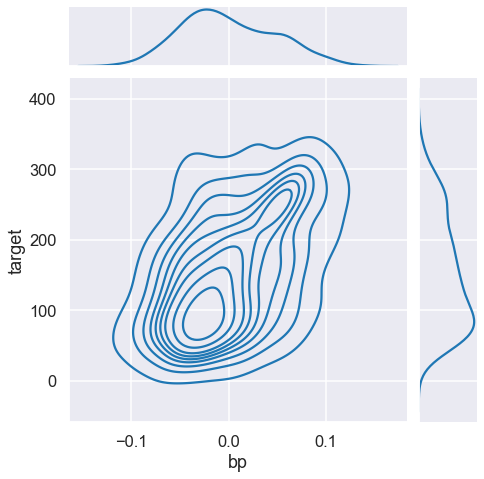

In [9]:
#Distribuzione tra bp e il target
sns.jointplot(df.bp, df_target.target, kind="kde", size=7)
plt.show()

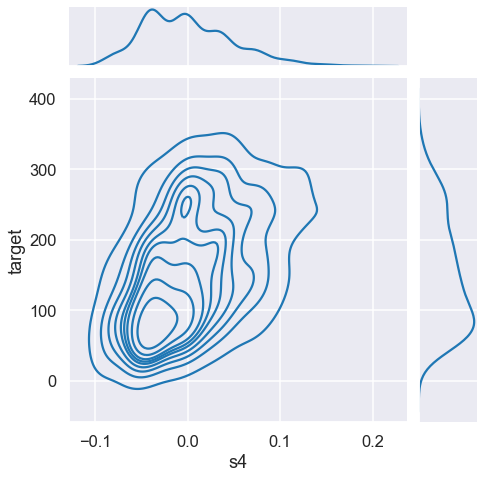

In [10]:
#Distribuzione tra s4 e il target
sns.jointplot(df.s4, df_target.target, kind="kde", size=7)
plt.show()

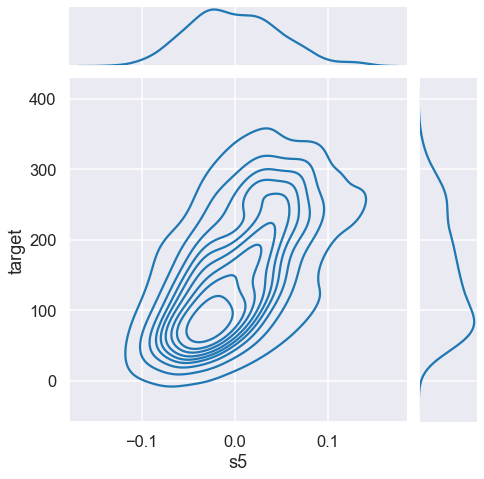

In [11]:
#Distribuzione tra s5 e il target
sns.jointplot(df.s5, df_target.target, kind="kde", size=7)
plt.show()

## Divido in Training e Test 

In [12]:
print("Dataset: {}{}".format(X.shape,y.shape))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=4)

print("Training set:{}{}".format(X_train.shape,y_train.shape))
print("Testing set:{}".format(X_test.shape,y_test.shape))

Dataset: (442, 10)(442,)
Training set:(353, 10)(353,)
Testing set:(89, 10)


## Modello DecisionTreeRegressor e Tuning attraverso il GridSearchCV

In [13]:
param_grid = {"max_depth": [int(x) for x in np.arange(2,20,1)],
              "min_samples_split": [int(x) for x in np.arange(2,30,1)],
              "min_samples_leaf": [int(x) for x in np.arange(2,30,1)],
              }

#numero di tentativi 18*28*28 = 14112
#I tempi di attesa sono brevi in quanto il dataset è di piccole dimensioni

grid_cv_dtr = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs= -1)

grid_cv_dtr.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 29]})

## Valutazione

In [14]:
print("R2:{}".format(grid_cv_dtr.best_score_))
print("Best Hyperparameters:\n{}".format(grid_cv_dtr.best_params_))

R2:0.39786713017758524
Best Hyperparameters:
{'max_depth': 3, 'min_samples_leaf': 26, 'min_samples_split': 2}


In [15]:
#visualizzo i record del dataframe contenente i risultati del GridSearchCV
df = pd.DataFrame(data=grid_cv_dtr.cv_results_)
df.sort_values(by='mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1458,0.001631,0.003261,0.000405,0.000809,3,26,4,"{'max_depth': 3, 'min_samples_leaf': 26, 'min_...",0.529217,0.479725,0.149316,0.411283,0.419795,0.397867,0.131447,1
1471,0.008601,0.003249,0.004521,0.003952,3,26,17,"{'max_depth': 3, 'min_samples_leaf': 26, 'min_...",0.529217,0.479725,0.149316,0.411283,0.419795,0.397867,0.131447,1
1461,0.002011,0.003110,0.000000,0.000000,3,26,7,"{'max_depth': 3, 'min_samples_leaf': 26, 'min_...",0.529217,0.479725,0.149316,0.411283,0.419795,0.397867,0.131447,1
1457,0.001810,0.002723,0.000000,0.000000,3,26,3,"{'max_depth': 3, 'min_samples_leaf': 26, 'min_...",0.529217,0.479725,0.149316,0.411283,0.419795,0.397867,0.131447,1
1456,0.000199,0.000399,0.000218,0.000436,3,26,2,"{'max_depth': 3, 'min_samples_leaf': 26, 'min_...",0.529217,0.479725,0.149316,0.411283,0.419795,0.397867,0.131447,1


L'iperparmentro "max_depth" a 3, con la sequanza di parametri passati dal dizionario "param_grid" usando la GridSearchCV, risualta essere per moltissimi dei risultati la scelta giusta, anche se i risultati generali non sono promettenti, in quanto restituisce un R-square massimo di 0.4

## Performance Dataset di Test

In [16]:
#assegno alla variabile il modello con i parametri migliori
best_dtr_model = grid_cv_dtr.best_estimator_

In [17]:
#e predico utilizzando i dati di test
y_pred = best_dtr_model.predict(X_test)

In [18]:
#valuto il modello
r2_score = best_dtr_model.score(X_test,y_test)
print("R2: {}".format(r2_score))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))
print("MAE: %.2f" % metrics.mean_absolute_error(y_test, y_pred))

R2: 0.3503858104092513
MSE: 3543.23
MAE: 47.76


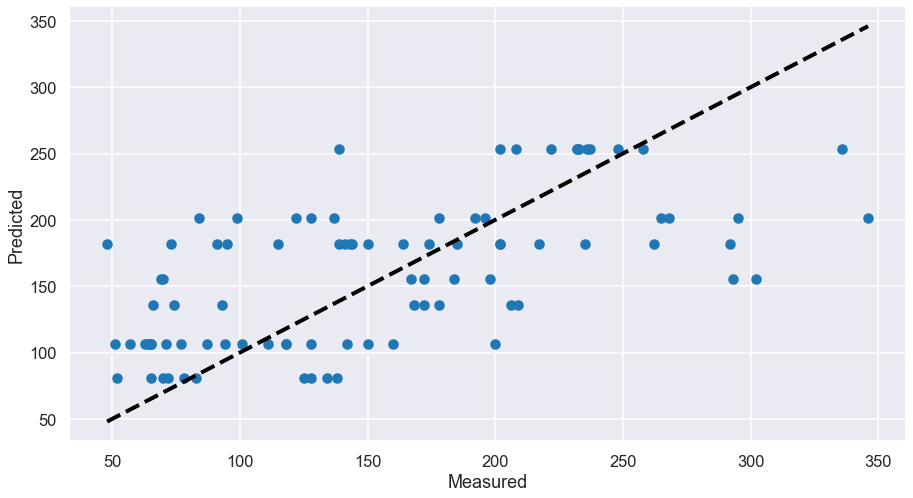

In [19]:
#visualizzo i valori predetti e quelli del test set
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

CONSIDERAZIONI: Il nodello predittivo utilizzato, anche ottimizzando i suoi iperparametri, non reagisce bene al dataset in questione. Restituisce un score R-square di 0.35, rendendolo di fatto inultile. Pertanto provo a rimuovere alcune features meno significative per vedere se il nostro risultato migliora, ma sicuramente per questo tipo di problema dobbiamo ricorrere ad un'altro algoritmo di risoluzione.

## Selezione features più importanti

In [20]:
#feature per intero
diabetes["feature_names"]

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [21]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

#seleziono solamente le features: "bmi", "bp", "s4", "s5", in quanto hanno una correlazione superiore allo 0.5
predictor_variables = [2,8]
X_train = X_train[predictor_variables]
X_test = X_test[predictor_variables]

print("Training set: {}{}".format(X_train.shape,y_train.shape))
print("Testing set: {}{}".format(X_test.shape, y_test.shape))

Training set: (353, 2)(353,)
Testing set: (89, 2)(89,)


In [22]:
#riprovo utilizzando il dataset al netto delle feature meno significative

param_grid = {"max_depth": [int(x) for x in np.arange(2,20,1)],
              "min_samples_split": [int(x) for x in np.arange(2,30,1)],
              "min_samples_leaf": [int(x) for x in np.arange(2,30,1)],
              }

#numero di tentativi 18*28*28 = 14112

grid_cv_dtr = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs= -1)

grid_cv_dtr.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 29]})

## Performance Dataset di Test escudendo le feature irrilevanti

In [23]:
#stampo il miglior risultato R-square
print("R2: {}".format(grid_cv_dtr.best_score_))
print("Best Hyperparameters:\n{}".format(grid_cv_dtr.best_params_))

R2: 0.43674044986167126
Best Hyperparameters:
{'max_depth': 3, 'min_samples_leaf': 13, 'min_samples_split': 2}


In [24]:
best_dtr_model = grid_cv_dtr.best_estimator_

In [25]:
y_pred = best_dtr_model.predict(X_test)

In [26]:
#valuto il modello
r2_score = best_dtr_model.score(X_test,y_test)
print("R2: {}".format(r2_score))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))
print("MAE: %.2f" % metrics.mean_absolute_error(y_test, y_pred))

R2: 0.3957930375581439
MSE: 3295.56
MAE: 46.52


## Conclusioni

Nonostante un sensibile miglioramento dello score R-square a 0.39, a seguito della rimozione di alcune features, come pronosticato il modello utilizzato non ci consente di sviluppare un'algoritmo soddisfacente per la risoluzione del problema. Pertanto siamo costretti ad utilizzare altre soluzioni.